# Trade Agreements & Vaccine Pricing: Causal Analysis
---

In [2]:
pip install pandas country_converter matplotlib seaborn numpy econml xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Imports & Setup

In [ ]:
import os
import pandas as pd
import country_converter as coco
from itertools import permutations
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
from econml.dml import CausalForestDML
from xgboost import XGBRegressor

## 2. Data Loading

In [ ]:
BASE_DIR = os.path.dirname(os.path.abspath(__file__))
DATA_DIR = os.path.join(BASE_DIR, 'data')

df = pd.read_csv(os.path.join(DATA_DIR, 'Chemicals_Allied_Industries.csv'))

df = df.rename(columns={'mfn': 'standard_rate', 'prf': 'preferential_rate'})

pharma_tariffs = len(df[df['hs2']==30])
print(pharma_tariffs)

pharma_trade_df = df[df['hs2']==30]

60546


In [5]:
!pip install xlrd
!pip install openpyxl


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
wto_x_ac = pd.read_excel(r'C:\Users\srima\Downloads\pta-agreements_1.xls', sheet_name='WTO-X AC')
wto_x_le = pd.read_excel(r'C:\Users\srima\Downloads\pta-agreements_1.xls', sheet_name='WTO-X LE')

vaccine_df = pd.read_excel(r'C:\Users\srima\OneDrive\Desktop\INSY674\Individual Project 1\who-mi4a-dataset-final-september-2025.xlsx', sheet_name='Vaccine purchase database')

## 3. Data Merging

### 3.1 WTO-X AC: Parse Agreements into Partner Pairs

In [7]:
# Split on em-dash, en-dash, or hyphen with optional surrounding whitespace
partners = wto_x_ac['Agreement'].str.split(r'\s*[\u2014\u2013-]\s*', regex=True)

# Find the max number of partners across all rows
max_partners = partners.str.len().max()

# Build Partner 1, Partner 2, ... Partner N columns
for i in range(max_partners):
    col = f'Partner {i + 1}'
    wto_x_ac[col] = partners.str[i]

# Rows with no dash (only 1 element after split) -> set all partner cols to 'N/A'
partner_cols = [f'Partner {i + 1}' for i in range(max_partners)]
no_dash = partners.str.len() == 1
wto_x_ac.loc[no_dash, partner_cols] = 'N/A'

# Convert partner names to ISO3 codes ('N/A' for trade blocs like ASEAN, Pacific Partnership, etc.)
for col in partner_cols:
    converted = coco.convert(wto_x_ac[col].fillna('N/A').tolist(), to='ISO3', not_found='N/A')
    wto_x_ac[f'{col} ISO3'] = [v[0] if isinstance(v, list) else v for v in converted]

# Remove duplicate columns (can happen if cells above were re-run)
wto_x_ac = wto_x_ac.loc[:, ~wto_x_ac.columns.duplicated(keep='last')]

# Build all ordered partner pairs per agreement (so both directions are covered)
iso3_cols = [f'Partner {i+1} ISO3' for i in range(max_partners)]
pair_rows = []
for idx, row in wto_x_ac.iterrows():
    codes = [row[c] for c in iso3_cols if isinstance(row[c], str) and row[c] != 'N/A']
    for a, b in permutations(codes, 2):
        pair_rows.append({**row.to_dict(), 'reporter_iso3': a, 'partner_iso3': b})

wto_ac_pairs = pd.DataFrame(pair_rows)

N/A not found in ISO3
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
CAFTA not found in regex
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
EFTA not found in regex
EFTA not found in regex
EU not found in ISO2
EU not found in ISO2
N/A not found in ISO3
N/A not found in ISO3
MERCOSUR not found in regex
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
Trans not found in regex
EFTA not found in regex
EFTA not found in regex
EFTA not found in regex
EU not found in ISO2
EFTA not found in regex
Gulf Cooperation Council (GCC) not found in regex
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
Asia Pacific Trade

### 3.2 WTO-X LE: Parse Agreements into Partner Pairs

In [8]:
# Split Agreement column into partner columns (same logic as wto_x_ac)
le_partners = wto_x_le['Agreement'].str.split(r'\s*[\u2014\u2013-]\s*', regex=True)
for i in range(max_partners):
    col = f'Partner {i + 1}'
    wto_x_le[col] = le_partners.str[i]

le_no_dash = le_partners.str.len() == 1
wto_x_le.loc[le_no_dash, partner_cols] = 'N/A'

# Convert partner names to ISO3 codes
for col in partner_cols:
    converted = coco.convert(wto_x_le[col].fillna('N/A').tolist(), to='ISO3', not_found='N/A')
    wto_x_le[f'{col} ISO3'] = [v[0] if isinstance(v, list) else v for v in converted]

# Remove duplicate columns (can happen if cells above were re-run)
wto_x_le = wto_x_le.loc[:, ~wto_x_le.columns.duplicated(keep='last')]

le_pair_rows = []
for idx, row in wto_x_le.iterrows():
    codes = [row[c] for c in iso3_cols if isinstance(row[c], str) and row[c] != 'N/A']
    for a, b in permutations(codes, 2):
        le_pair_rows.append({**row.to_dict(), 'reporter_iso3': a, 'partner_iso3': b})

wto_le_pairs = pd.DataFrame(le_pair_rows)

N/A not found in ISO3
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
CAFTA not found in regex
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
EFTA not found in regex
EFTA not found in regex
EU not found in ISO2
EU not found in ISO2
N/A not found in ISO3
N/A not found in ISO3
MERCOSUR not found in regex
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
Trans not found in regex
EFTA not found in regex
EFTA not found in regex
EFTA not found in regex
EU not found in ISO2
EFTA not found in regex
Gulf Cooperation Council (GCC) not found in regex
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
Asia Pacific Trade

### 3.3 Merge WTO-X AC + WTO-X LE + Pharma Trade Data

In [9]:
# Merge WTO-X AC and WTO-X LE pair DataFrames on reporter/partner ISO3
wto_merged = wto_ac_pairs.merge(
    wto_le_pairs,
    on=['reporter_iso3', 'partner_iso3'],
    how='outer',
    suffixes=('_ac', '_le')
)

# Merge WTO combined data with pharma trade data
final_merged = pharma_trade_df.merge(
    wto_merged,
    left_on=['reporteriso3', 'partneriso3'],
    right_on=['reporter_iso3', 'partner_iso3'],
    how='outer'
)

print(final_merged.head())
final_merged['partneriso3'].value_counts()

  reporteriso3       hs6 partneriso3  standard_rate  preferential_rate  PTA  \
0          ABW  300390.0         BRA            6.0                6.0  0.0   
1          ABW  300490.0         BRA            6.0                6.0  0.0   
2          ABW  300610.0         BRA            6.0                6.0  0.0   
3          ABW  300220.0         CHN            6.0                6.0  0.0   
4          ABW  300590.0         CHN            6.0                6.0  0.0   

    hs2                                 sector  broad_sectors  pfm  ...  \
0  30.0  28-38  Chemicals & Allied Industries   Manufacturing  0.0  ...   
1  30.0  28-38  Chemicals & Allied Industries   Manufacturing  0.0  ...   
2  30.0  28-38  Chemicals & Allied Industries   Manufacturing  0.0  ...   
3  30.0  28-38  Chemicals & Allied Industries   Manufacturing  0.0  ...   
4  30.0  28-38  Chemicals & Allied Industries   Manufacturing  0.0  ...   

  Statistics_le Taxation_le Terrorism_le VisaandAsylum_le Partner 1_le  \


partneriso3
USA    2683
DEU    2523
FRA    2396
GBR    2322
ITA    2011
       ... 
GNB       1
TUV       1
ESH       1
STP       1
SSD       1
Name: count, Length: 230, dtype: int64

## 4. Data Cleaning

### 4.1 Drop WTO-X AC columns (keep LE only)

In [10]:
final_merged['Terrorism_ac'].value_counts()
final_merged['Terrorism_le'].value_counts()

final_merged['Health_ac'].value_counts()
final_merged['Health_le'].value_counts()

Health_le
0.0    3386
1.0     131
2.0      87
Name: count, dtype: int64

In [11]:
# Since the WTO-X_LE dataset has more provisions and also a more granular breakdown between mentioned agreements
# vs mentioned legally enforceable agreements, we will use the columns derived from the WTO-X_LE dataset

# Drop all columns with the _ac suffix
final_merged = final_merged.drop(columns=[c for c in final_merged.columns if c.endswith('_ac')])

final_merged.columns

Index(['reporteriso3', 'hs6', 'partneriso3', 'standard_rate',
       'preferential_rate', 'PTA', 'hs2', 'sector', 'broad_sectors', 'pfm',
       'reporter_region', 'reporter_dev', 'reporter_wbgroup', 'partner_region',
       'partner_dev', 'partner_wbgroup', 'reporter_iso3', 'partner_iso3',
       'Agreement_le', 'Date_le', 'year_le', 'Type_le', 'AntiCorruption_le',
       'CompetitionPolicy_le', 'EnvironmentalLaws_le', 'IPR_le',
       'Investment_le', 'LabourMarketRegulation_le', 'MovementofCapital_le',
       'ConsumerProtection_le', 'DataProtection_le', 'Agriculture_le',
       'ApproximationofLegislation_le', 'AudioVisual_le', 'CivilProtection_le',
       'InnovationPolicies_le', 'CulturalCooperation_le',
       'EconomicPolicyDialogue_le', 'EducationandTraining_le', 'Energy_le',
       'FinancialAssistance_le', 'Health_le', 'HumanRights_le',
       'IllegalImmigration_le', 'IllicitDrugs_le', 'IndustrialCooperation_le',
       'InformationSociety_le', 'Mining_le', 'MoneyLaundering

### 4.2 Keep only healthcare-related trade provisions

In [12]:
# Keeping covariates related to healthcare related trade agreements --> illicit drugs, R&D, IPR,
# Consumer Protection, Innovation, EnvironmentalLaws, SocialMatters

cols_to_exclude = ['Agreement_le', 'Date_le', 'year_le', 'Type_le',
                   'Partner 1_le', 'Partner 2_le', 'Partner 3_le',
                   'Partner 1 ISO3_le', 'Partner 2 ISO3_le', 'Partner 3 ISO3_le']
cols_to_exclude_2 = ['EnvironmentalLaws_le','IPR_le','ConsumerProtection_le','InnovationPolicies_le','Health_le','IllicitDrugs_le','SocialMatters_le']
final_merged = final_merged.drop(columns=[c for c in final_merged.columns if c.endswith('_le') and c not in cols_to_exclude+cols_to_exclude_2])

final_merged.columns

Index(['reporteriso3', 'hs6', 'partneriso3', 'standard_rate',
       'preferential_rate', 'PTA', 'hs2', 'sector', 'broad_sectors', 'pfm',
       'reporter_region', 'reporter_dev', 'reporter_wbgroup', 'partner_region',
       'partner_dev', 'partner_wbgroup', 'reporter_iso3', 'partner_iso3',
       'Agreement_le', 'Date_le', 'year_le', 'Type_le', 'EnvironmentalLaws_le',
       'IPR_le', 'ConsumerProtection_le', 'InnovationPolicies_le', 'Health_le',
       'IllicitDrugs_le', 'SocialMatters_le', 'Partner 1_le', 'Partner 2_le',
       'Partner 3_le', 'Partner 1 ISO3_le', 'Partner 2 ISO3_le',
       'Partner 3 ISO3_le'],
      dtype='object')

### 4.3 Validate partner ISO3 matches

In [13]:
final_merged[['reporteriso3','partneriso3','reporter_iso3','partner_iso3','Partner 1_le', 'Partner 2_le',
       'Partner 3_le', 'Partner 1 ISO3_le', 'Partner 2 ISO3_le',
       'Partner 3 ISO3_le']]

final_merged['Partner 1 ISO3_le'].value_counts()

Partner 1 ISO3_le
RUS    470
USA    351
CHL    246
KOR    230
CHN    226
JPN    226
CAN    215
AUS    207
TUR    182
IND    148
PAN    133
N/A    121
ECU    102
PER     88
UKR     70
KGZ     63
GEO     59
ARM     56
COL     50
NZL     40
CHE     37
CRI     35
HKG     35
MEX     33
SLV     29
MYS     23
PAK     23
LAO     20
ISR     14
ISL     13
THA     13
BRN     10
EGY      9
ZAF      9
FRO      4
JOR      4
MUS      4
GTM      2
NIC      2
SGP      2
Name: count, dtype: int64

In [14]:
# Check how many rows have matching Partner 1 ISO3_le and reporteriso3
match_count = (final_merged['Partner 1 ISO3_le'] == final_merged['reporteriso3']).sum()
total_count = final_merged[['Partner 1 ISO3_le', 'reporteriso3']].dropna().shape[0]
print(f"Matching rows: {match_count} / {total_count} ({match_count/total_count*100:.1f}%)")

# 1/3 of the columns match...maybe the provisions under the current mandate of WTO are just as important
# For the reasoning previously mentioned, we will only keep the WTO+LE sheet

Matching rows: 1340 / 3388 (39.6%)


### 4.4 Merge WTO+ LE data

In [15]:
wto_plus = pd.read_excel(r"C:\Users\srima\OneDrive\Desktop\INSY674\Individual Project 1\pta-agreements_1.xls", sheet_name='WTO+ LE')

partners_plus = wto_plus['Agreement'].str.split(r'\s*[\u2014\u2013-]\s*', regex=True)

max_partners_plus = partners_plus.str.len().max()

# Build Partner 1, Partner 2, ... Partner N columns
for i in range(max_partners_plus):
    col = f'Partner {i + 1}'
    wto_plus[col] = partners_plus.str[i]

# Rows with no dash (only 1 element after split) -> set all partner cols to 'N/A'
partner_cols = [f'Partner {i + 1}' for i in range(max_partners_plus)]
no_dash = partners_plus.str.len() == 1
wto_plus.loc[no_dash, partner_cols] = 'N/A'

for col in partner_cols:
    converted = coco.convert(wto_plus[col].fillna('N/A').tolist(), to='ISO3', not_found='N/A')
    wto_plus[f'{col} ISO3'] = [v[0] if isinstance(v, list) else v for v in converted]

# Remove duplicate columns (can happen if cells above were re-run)
wto_plus = wto_plus.loc[:, ~wto_plus.columns.duplicated(keep='last')]

# Build all ordered partner pairs per agreement (so both directions are covered)
iso3_cols = [f'Partner {i+1} ISO3' for i in range(max_partners_plus)]
pair_rows = []
for idx, row in wto_plus.iterrows():
    codes = [row[c] for c in iso3_cols if isinstance(row[c], str) and row[c] != 'N/A']
    for a, b in permutations(codes, 2):
        pair_rows.append({**row.to_dict(), 'reporter_iso3': a, 'partner_iso3': b})

wto_plus_pairs = pd.DataFrame(pair_rows)

print(wto_plus.columns.tolist())
print(wto_plus_pairs.columns.tolist())

N/A not found in ISO3
ASEAN not found in regex
ASEAN not found in regex
ASEAN not found in regex
CAFTA not found in regex
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
EFTA not found in regex
EFTA not found in regex
EU not found in ISO2
EU not found in ISO2
N/A not found in ISO3
N/A not found in ISO3
MERCOSUR not found in regex
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
Trans not found in regex
EFTA not found in regex
EFTA not found in regex
EFTA not found in regex
EU not found in ISO2
EFTA not found in regex
Gulf Cooperation Council (GCC) not found in regex
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
N/A not found in ISO3
Asia Pacific Trade

['Agreement', 'Date', 'year', 'Type', 'FTAIndustrial', 'FTAAgriculture', 'Customs', 'ExportTaxes', 'SPS', 'TBT', 'STE', 'AD', 'CVM', 'StateAid', 'PublicProcurement', 'TRIMs', 'GATS', 'TRIPs', 'Partner 1', 'Partner 2', 'Partner 3', 'Partner 1 ISO3', 'Partner 2 ISO3', 'Partner 3 ISO3']
['Agreement', 'Date', 'year', 'Type', 'FTAIndustrial', 'FTAAgriculture', 'Customs', 'ExportTaxes', 'SPS', 'TBT', 'STE', 'AD', 'CVM', 'StateAid', 'PublicProcurement', 'TRIMs', 'GATS', 'TRIPs', 'Partner 1', 'Partner 2', 'Partner 3', 'Partner 1 ISO3', 'Partner 2 ISO3', 'Partner 3 ISO3', 'reporter_iso3', 'partner_iso3']


In [16]:
# Merge WTO+ LE pairs with final_merged on reporter/partner ISO3
print(f"Before merge: final_merged has {final_merged.shape[1]} cols, wto_plus_pairs has {wto_plus_pairs.shape[1]} cols")
final_merged = final_merged.merge(
    wto_plus_pairs,
    on=['reporter_iso3', 'partner_iso3'],
    how='outer',
    suffixes=('', '_plus')
)
print(f"After merge: final_merged has {final_merged.shape[1]} cols, {final_merged.shape[0]} rows")
print([c for c in final_merged.columns if 'plus' in c or 'ISO3' in c])

print(final_merged.columns.tolist())

Before merge: final_merged has 35 cols, wto_plus_pairs has 26 cols
After merge: final_merged has 59 cols, 62642 rows
['Partner 1 ISO3_le', 'Partner 2 ISO3_le', 'Partner 3 ISO3_le', 'Partner 1 ISO3', 'Partner 2 ISO3', 'Partner 3 ISO3']
['reporteriso3', 'hs6', 'partneriso3', 'standard_rate', 'preferential_rate', 'PTA', 'hs2', 'sector', 'broad_sectors', 'pfm', 'reporter_region', 'reporter_dev', 'reporter_wbgroup', 'partner_region', 'partner_dev', 'partner_wbgroup', 'reporter_iso3', 'partner_iso3', 'Agreement_le', 'Date_le', 'year_le', 'Type_le', 'EnvironmentalLaws_le', 'IPR_le', 'ConsumerProtection_le', 'InnovationPolicies_le', 'Health_le', 'IllicitDrugs_le', 'SocialMatters_le', 'Partner 1_le', 'Partner 2_le', 'Partner 3_le', 'Partner 1 ISO3_le', 'Partner 2 ISO3_le', 'Partner 3 ISO3_le', 'Agreement', 'Date', 'year', 'Type', 'FTAIndustrial', 'FTAAgriculture', 'Customs', 'ExportTaxes', 'SPS', 'TBT', 'STE', 'AD', 'CVM', 'StateAid', 'PublicProcurement', 'TRIMs', 'GATS', 'TRIPs', 'Partner 1', 

### 4.5 Verify country row matches across all datasets

In [17]:
match_count = (final_merged['Partner 1 ISO3_le'] == final_merged['reporteriso3']).sum()
total_count = final_merged[['Partner 1 ISO3_le', 'reporteriso3']].dropna().shape[0]
print(f"Matching rows: {match_count} / {total_count} ({match_count/total_count*100:.1f}%)")

match2_count = (final_merged['Partner 2 ISO3_le'] == final_merged['partneriso3']).sum()
total2_count = final_merged[['Partner 2 ISO3_le', 'partneriso3']].dropna().shape[0]
print(f"Matching rows: {match2_count} / {total2_count} ({match2_count/total2_count*100:.1f}%)")

match_plus_count = (final_merged['Partner 1 ISO3'] == final_merged['reporteriso3']).sum()
total_plus_count = final_merged[['Partner 1 ISO3', 'reporteriso3']].dropna().shape[0]
print(f"Matching rows: {match_plus_count} / {total_plus_count} ({match_plus_count/total_plus_count*100:.1f}%)")

match_plus2_count = (final_merged['Partner 2 ISO3'] == final_merged['partneriso3']).sum()
total_plus2_count = final_merged[['Partner 2 ISO3', 'partneriso3']].dropna().shape[0]
print(f"Matching rows: {match_plus2_count} / {total_plus2_count} ({match_plus2_count/total_plus2_count*100:.1f}%)")

print(wto_plus_pairs.shape)
print(wto_plus_pairs.columns.tolist())
wto_plus_pairs['Partner 1 ISO3'].value_counts()

Matching rows: 1526 / 3948 (38.7%)
Matching rows: 1612 / 3948 (40.8%)
Matching rows: 1526 / 3948 (38.7%)
Matching rows: 1612 / 3948 (40.8%)
(418, 26)
['Agreement', 'Date', 'year', 'Type', 'FTAIndustrial', 'FTAAgriculture', 'Customs', 'ExportTaxes', 'SPS', 'TBT', 'STE', 'AD', 'CVM', 'StateAid', 'PublicProcurement', 'TRIMs', 'GATS', 'TRIPs', 'Partner 1', 'Partner 2', 'Partner 3', 'Partner 1 ISO3', 'Partner 2 ISO3', 'Partner 3 ISO3', 'reporter_iso3', 'partner_iso3']


Partner 1 ISO3
ECU    48
TUR    34
CHL    30
JPN    22
RUS    22
USA    22
PAN    20
CAN    20
CHN    18
IND    16
UKR    16
KOR    14
KGZ    12
GEO    12
SLV    10
AUS    10
ARM    10
PER    10
HKG     8
NZL     6
CRI     6
ISL     4
FRO     4
N/A     4
COL     4
MEX     4
PAK     4
ZAF     4
JOR     2
SGP     2
THA     2
EGY     2
ISR     2
GTM     2
BRN     2
MYS     2
LAO     2
MUS     2
NIC     2
CHE     2
Name: count, dtype: int64

### 4.6 Drop duplicate / redundant columns

In [18]:
final_merged.columns

# Check for columns with duplicate rows
final_merged[['Partner 2 ISO3','Partner 2 ISO3_le']]  # identical, drop one of them

final_merged = final_merged.drop(columns=['Partner 1 ISO3_le', 'Partner 2 ISO3_le', 'Partner 3 ISO3_le'])

final_merged.columns

Index(['reporteriso3', 'hs6', 'partneriso3', 'standard_rate',
       'preferential_rate', 'PTA', 'hs2', 'sector', 'broad_sectors', 'pfm',
       'reporter_region', 'reporter_dev', 'reporter_wbgroup', 'partner_region',
       'partner_dev', 'partner_wbgroup', 'reporter_iso3', 'partner_iso3',
       'Agreement_le', 'Date_le', 'year_le', 'Type_le', 'EnvironmentalLaws_le',
       'IPR_le', 'ConsumerProtection_le', 'InnovationPolicies_le', 'Health_le',
       'IllicitDrugs_le', 'SocialMatters_le', 'Partner 1_le', 'Partner 2_le',
       'Partner 3_le', 'Agreement', 'Date', 'year', 'Type', 'FTAIndustrial',
       'FTAAgriculture', 'Customs', 'ExportTaxes', 'SPS', 'TBT', 'STE', 'AD',
       'CVM', 'StateAid', 'PublicProcurement', 'TRIMs', 'GATS', 'TRIPs',
       'Partner 1', 'Partner 2', 'Partner 3', 'Partner 1 ISO3',
       'Partner 2 ISO3', 'Partner 3 ISO3'],
      dtype='object')

In [19]:
final_merged[['Partner 1 ISO3', 'Partner 1']]
final_merged[['Partner 2 ISO3', 'Partner 2']]
final_merged[['Partner 3 ISO3', 'Partner 3']].value_counts()  # Partner 3 ISO3 is all N/A, drop it

# Where Partner 3 ISO3 is 'N/A' but Partner 3 has a name (e.g., ASEAN, Central America), copy the name over
mask = (final_merged['Partner 3 ISO3'] == 'N/A') & (final_merged['Partner 3'].notna()) & (final_merged['Partner 3'] != 'N/A')
final_merged.loc[mask, 'Partner 3 ISO3'] = final_merged.loc[mask, 'Partner 3']

### 4.7 Vaccine data cleaning & reload

In [20]:
vaccine_df = pd.read_excel(r"C:\Users\srima\OneDrive\Desktop\INSY674\Individual Project 1\who-mi4a-dataset-final-september-2025.xlsx", sheet_name='Vaccine purchase database')

print(vaccine_df.columns.tolist())
vaccine_df['Region']
final_merged.head()
vaccine_df.head()

['Region', 'Income Group', 'Gavi Non Gavi', 'Country alias 2025', 'Year', 'Vaccine', 'Manufacturer', 'Presentation', 'Dosage Number', 'Annual Number of Doses', 'WHO PQ', 'CommercialName', 'Procurement Mechanism', 'ContractLength', 'Price per Dose in USD', 'INCOTerm', 'VATPercent', 'VATName']


,Region,Income Group,Gavi Non Gavi,Country alias 2025,Year,Vaccine,Manufacturer,Presentation,Dosage Number,Annual Number of Doses,WHO PQ,CommercialName,Procurement Mechanism,ContractLength,Price per Dose in USD,INCOTerm,VATPercent,VATName
0,WPRO,LMIC,Non-Gavi,LMIC7246,2005,HepB (ped.),Sanofi Healthcare India Private Limited (India),Vial,10.0,7000000.0,No,Shanvac-B,UNICEF SD,1 year,0.230,NaN,NaN,Does not include
1,WPRO,LMIC,Non-Gavi,LMIC7246,2005,BCG,Japan BCG Laboratory,Ampoule,20.0,7000000.0,Yes,BCG Freeze Dried Glutamate vaccine,UNICEF SD,1 year,NaN,NaN,NaN,Does not include
2,WPRO,LMIC,Non-Gavi,LMIC7246,2005,DTwP,Serum Institute of India Pvt. Ltd.,Vial,20.0,11400000.0,Yes,Diphtheria-Tetanus-Pertussis Vaccine Adsorbed,UNICEF SD,1 year,0.090,NaN,NaN,Does not include
3,WPRO,LMIC,Non-Gavi,LMIC7246,2005,Measles,Serum Institute of India Pvt. Ltd.,Vial,10.0,3000000.0,Yes,"Measles Vaccine, Live attenuated",UNICEF SD,1 year,0.140,NaN,NaN,Does not include
4,WPRO,LMIC,Non-Gavi,LMIC7246,2005,tOPV,GlaxoSmithKline Biologicals SA,Vial,20.0,4000000.0,Yes,Polio sabin,UNICEF SD,1 year,0.118,NaN,NaN,Does not include


## 5. Data Preprocessing

### 5.1 WHO Region Assignment

In [21]:
AFRO = ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic', 'Chad', 'Comoros', "C\u00f4te d'Ivoire", 'Democratic Republic of the Congo', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', "Republic of the Congo", "Rwanda", "Sao Tome and Principe", "Senegal", "Seychelles", "Sierra Leone", "South Africa", "Swaziland", "Togo", "Uganda", "United Republic of Tanzania", "Zambia", "Zimbabwe"]

AMRO = ['Antigua and Barbuda', 'Anguilla', 'Argentina', 'Bahamas', 'Barbados', 'Belize', 'Bermuda', 'Bolivia (Plurinational State of)', 'Brazil', 'British Virgin Islands', 'Canada', 'Cayman Islands', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Grenada', 'Guatemala', 'Guyana', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Suriname", "Trinidad and Tobago", "Turks and Caicos", "United States of America", "Uruguay", "Venezuela (Bolivarian Republic of)"]

EMRO = ['Afghanistan', 'Bahrain', 'Djibouti', 'Egypt', 'Iran (Islamic Republic of)', 'Iraq', 'Jordan', 'Kuwait', 'Lebanon', 'Libyan Arab Jamahiriya', 'Morocco', 'Oman', 'Pakistan', 'Palestine', 'Qatar', 'Saudi Arabia', 'Somalia', 'Sudan', 'South Sudan', 'Syrian Arab Republic', 'Tunisia', 'United Arab Emirates', 'Yemen']

EURO = ['Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Kazakhstan', 'Kosovo', 'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal','Republic of Moldova','Romania','Russian Federation','San Marino','Serbia','Slovakia','Slovenia','Spain','Sweden','Switzerland','Tajikistan','Turkey','Turkmenistan','Ukraine','United Kingdom','Uzbekistan']

SEARO = ['Bangladesh', 'Bhutan', "Democratic People's Republic of Korea", 'India', 'Indonesia', 'Maldives', 'Myanmar', 'Nepal', 'Sri Lanka', 'Thailand', 'Timor-Leste']

WPRO = ['Australia', 'Brunei Darussalam', 'Cambodia', 'China', 'Cook Islands', 'Fiji', 'Japan', 'Kiribati', "Lao People's Democratic Republic", 'Malaysia', 'Marshall Islands', 'Micronesia (Federated States of)', 'Mongolia', 'Nauru', 'New Caledonia', 'New Zealand', 'Niue', 'Palau', 'Papua New Guinea', 'Philippines', 'Republic of Korea', 'Samoa', 'Singapore', 'Solomon Islands', 'Taiwan', 'Tonga', 'Tuvalu', 'Vanuatu', 'Viet Nam']

In [22]:
# Build a country -> WHO region lookup, then convert to ISO3 -> region
region_lists = {
    'AFRO': AFRO,
    'AMRO': AMRO,
    'EMRO': EMRO,
    'EURO': EURO,
    'SEARO': SEARO,
    'WPRO': WPRO,
}

iso3_to_region = {}
for region, countries in region_lists.items():
    iso3_codes = coco.convert(countries, to='ISO3', not_found=None)
    for code in iso3_codes:
        if code is not None:
            iso3_to_region[code] = region

# Create WHO region columns for reporter and partner
final_merged['reporter_WHO_region'] = final_merged['reporteriso3'].map(iso3_to_region)
final_merged['partner_WHO_region'] = final_merged['partneriso3'].map(iso3_to_region)

# Check for unmatched
unmatched_reporters = final_merged[final_merged['reporter_WHO_region'].isna()]['reporteriso3'].unique()
unmatched_partners = final_merged[final_merged['partner_WHO_region'].isna()]['partneriso3'].unique()
if len(unmatched_reporters) > 0:
    print(f"Unmatched reporter ISO3 codes: {unmatched_reporters}")
if len(unmatched_partners) > 0:
    print(f"Unmatched partner ISO3 codes: {unmatched_partners}")

print(final_merged[['reporteriso3', 'reporter_WHO_region', 'partneriso3', 'partner_WHO_region']].head(10))

Unmatched reporter ISO3 codes: [nan 'HKG' 'MAC' 'ABW' 'GRL' 'OAS']
Unmatched partner ISO3 codes: [nan 'HKG' 'MAC' 'FRO' 'CUW' 'UNS' 'FRE' 'OAS' 'MSR' 'ESH' 'GIB' 'ZAR'
 'UMI' 'ASM' 'SHN' 'VAT' 'ABW' 'BES' 'GUM' 'PYF' 'SPM' 'SXM' 'WLF' 'SUD'
 'GRL' 'TKL' 'IOT' 'BLM' 'FLK' 'TMP' 'MNP' 'SPE' 'BUN' 'CXR']
  reporteriso3 reporter_WHO_region partneriso3 partner_WHO_region
0          NaN                 NaN         NaN                NaN
1          NaN                 NaN         NaN                NaN
2          ALB                EURO         TUR               EURO
3          ALB                EURO         TUR               EURO
4          ALB                EURO         TUR               EURO
5          ALB                EURO         TUR               EURO
6          ALB                EURO         TUR               EURO
7          ALB                EURO         TUR               EURO
8          ALB                EURO         TUR               EURO
9          ALB                EURO   

### 5.2 Fix unmatched country codes

In [23]:
final_merged

unmatched_codes = list(set(unmatched_reporters).union(set(unmatched_partners)))
unmatched_names = coco.convert(unmatched_codes, to='name_short', not_found='Unknown')

print(pd.DataFrame({'ISO3': unmatched_codes, 'Country': unmatched_names}))

SPE not found in ISO3
UNS not found in ISO3
BUN not found in ISO3
nan not found in ISO3
OAS not found in ISO3
FRE not found in ISO3
ZAR not found in ISO3
SUD not found in ISO3
TMP not found in ISO3


   ISO3                               Country
0   SPE                               Unknown
1   UMI  United States Minor Outlying Islands
2   CUW                               Curaçao
3   ASM                        American Samoa
4   GUM                                  Guam
5   PYF                      French Polynesia
6   UNS                               Unknown
7   BUN                               Unknown
8   WLF             Wallis and Futuna Islands
9   NaN                               Unknown
10  MSR                            Montserrat
11  BLM                            St. Barths
12  CXR                      Christmas Island
13  TKL                               Tokelau
14  GIB                             Gibraltar
15  OAS                               Unknown
16  FRE                               Unknown
17  SHN                            St. Helena
18  FRO                         Faroe Islands
19  MNP              Northern Mariana Islands
20  ZAR                           

In [24]:
# Manually assigning them to a WHO region based on continent

unmatched_continents = coco.convert(unmatched_codes, to='continent', not_found='Unknown')

print(pd.DataFrame({'ISO3': unmatched_codes, 'Country': unmatched_names, 'Continent': unmatched_continents}))

# Assign WHO region based on continent
for code, continent in zip(unmatched_codes, unmatched_continents):
    if continent == 'Africa':
        iso3_to_region[code] = 'AFRO'
    elif continent == 'America':
        iso3_to_region[code] = 'AMRO'
    elif continent == 'Europe':
        iso3_to_region[code] = 'EMRO'
    elif continent in ('Asia', 'Oceania'):
        iso3_to_region[code] = 'WPRO'

# Re-map with the updated dictionary
final_merged['reporter_WHO_region'] = final_merged['reporteriso3'].map(iso3_to_region)
final_merged['partner_WHO_region'] = final_merged['partneriso3'].map(iso3_to_region)

# Verify no remaining unmatched
still_missing = final_merged[final_merged['reporter_WHO_region'].isna() | final_merged['partner_WHO_region'].isna()].shape[0]
print(f"Rows still missing a WHO region: {still_missing}")

SPE not found in ISO3
UNS not found in ISO3
BUN not found in ISO3
nan not found in ISO3
OAS not found in ISO3
FRE not found in ISO3
ZAR not found in ISO3
SUD not found in ISO3
TMP not found in ISO3


   ISO3                               Country Continent
0   SPE                               Unknown   Unknown
1   UMI  United States Minor Outlying Islands   Oceania
2   CUW                               Curaçao   America
3   ASM                        American Samoa   Oceania
4   GUM                                  Guam   Oceania
5   PYF                      French Polynesia   Oceania
6   UNS                               Unknown   Unknown
7   BUN                               Unknown   Unknown
8   WLF             Wallis and Futuna Islands   Oceania
9   NaN                               Unknown   Unknown
10  MSR                            Montserrat   America
11  BLM                            St. Barths   America
12  CXR                      Christmas Island      Asia
13  TKL                               Tokelau   Oceania
14  GIB                             Gibraltar    Europe
15  OAS                               Unknown   Unknown
16  FRE                               Unknown   

In [25]:
final_merged.shape

vaccine_df.dtypes
final_merged.dtypes

reporteriso3              object
hs6                      float64
partneriso3               object
standard_rate            float64
preferential_rate        float64
PTA                      float64
hs2                      float64
sector                    object
broad_sectors             object
pfm                      float64
reporter_region           object
reporter_dev              object
reporter_wbgroup          object
partner_region            object
partner_dev               object
partner_wbgroup           object
reporter_iso3             object
partner_iso3              object
Agreement_le              object
Date_le                   object
year_le                  float64
Type_le                   object
EnvironmentalLaws_le     float64
IPR_le                   float64
ConsumerProtection_le    float64
InnovationPolicies_le    float64
Health_le                float64
IllicitDrugs_le          float64
SocialMatters_le         float64
Partner 1_le              object
Partner 2_

## 6. Exploratory Data Analysis (EDA)

### 6.1 EDA on treatment variable: trade deal enactment

In [26]:
# Step 1: Check vaccine data year range
vaccine_df['Year'] = pd.to_numeric(vaccine_df['Year'], errors='coerce')
vaccine_df = vaccine_df.dropna(subset=['Year'])
vaccine_df['Year'] = vaccine_df['Year'].astype(int)

print(f"Vaccine Year range: {vaccine_df['Year'].min()} - {vaccine_df['Year'].max()}")

# Step 2: Check trade deal year range
final_merged['year']
final_merged['year'] = final_merged['year'].astype('Int64')
print(f'Trade deal range: {final_merged["year"].min()} - {final_merged["year"].max()}')

Vaccine Year range: 2005 - 2024
Trade deal range: 1973 - 2019


### 6.2 Trade deals by year

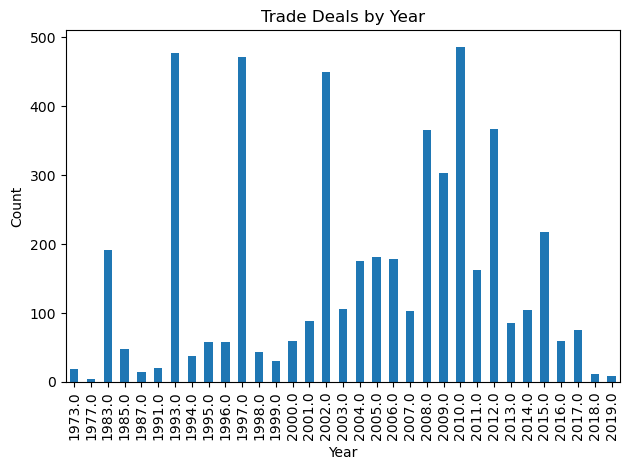

In [27]:
# Look at the distribution of the year variables to see if there's a breaking point
# to cluster countries into recency in which trade deals were enacted

final_merged['year_le'].value_counts().sort_index().plot(kind='bar')
plt.title('Trade Deals by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 6.3 Trade deals by WHO region

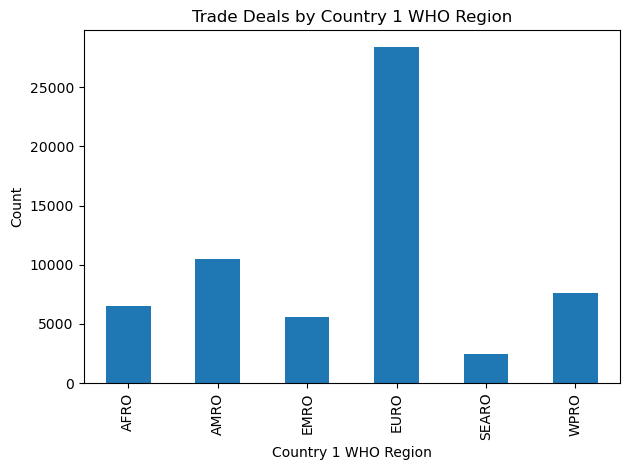

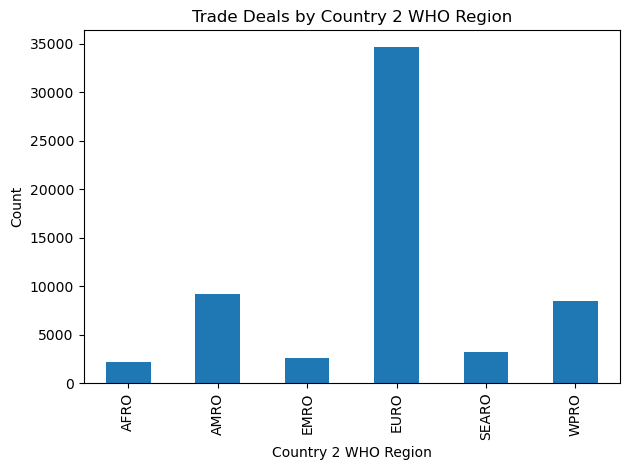

In [28]:
final_merged['reporter_WHO_region'].value_counts().sort_index().plot(kind='bar')
plt.title('Trade Deals by Country 1 WHO Region')
plt.xlabel('Country 1 WHO Region')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

final_merged['partner_WHO_region'].value_counts().sort_index().plot(kind='bar')
plt.title('Trade Deals by Country 2 WHO Region')
plt.xlabel('Country 2 WHO Region')
plt.ylabel('Count')
plt.tight_layout()
plt.show()  # European countries have the most number of trade deals

### 6.4 Countries with the most trade deals

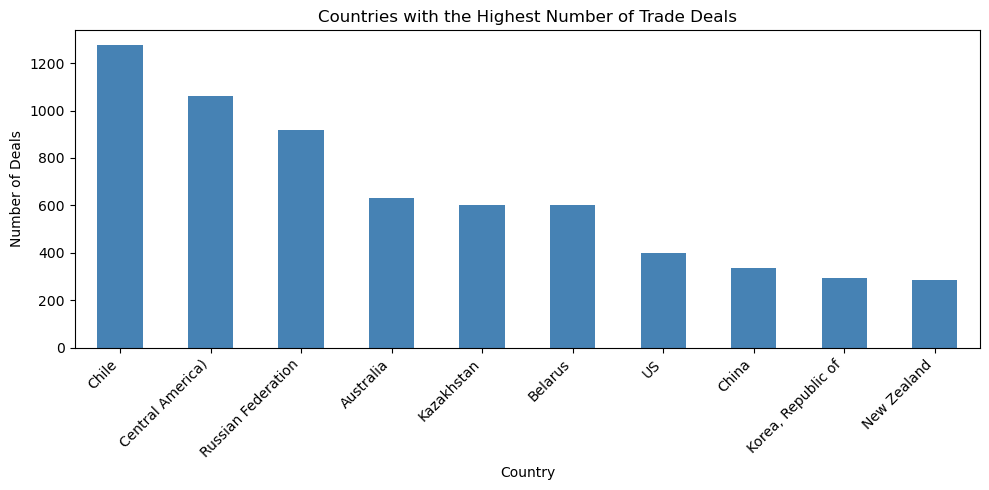

Index(['reporteriso3', 'hs6', 'partneriso3', 'standard_rate',
       'preferential_rate', 'PTA', 'hs2', 'sector', 'broad_sectors', 'pfm',
       'reporter_region', 'reporter_dev', 'reporter_wbgroup', 'partner_region',
       'partner_dev', 'partner_wbgroup', 'reporter_iso3', 'partner_iso3',
       'Agreement_le', 'Date_le', 'year_le', 'Type_le', 'EnvironmentalLaws_le',
       'IPR_le', 'ConsumerProtection_le', 'InnovationPolicies_le', 'Health_le',
       'IllicitDrugs_le', 'SocialMatters_le', 'Partner 1_le', 'Partner 2_le',
       'Partner 3_le', 'Agreement', 'Date', 'year', 'Type', 'FTAIndustrial',
       'FTAAgriculture', 'Customs', 'ExportTaxes', 'SPS', 'TBT', 'STE', 'AD',
       'CVM', 'StateAid', 'PublicProcurement', 'TRIMs', 'GATS', 'TRIPs',
       'Partner 1', 'Partner 2', 'Partner 3', 'Partner 1 ISO3',
       'Partner 2 ISO3', 'Partner 3 ISO3', 'reporter_WHO_region',
       'partner_WHO_region'],
      dtype='object')

In [29]:
# Count how often each country appears across Partner 1/2/3
country_counts = (
    final_merged[['Partner 1','Partner 2','Partner 3']]
    .stack()
    .value_counts()
)

country_counts.max()

# Plot
country_counts.nlargest(10).plot(kind='bar', figsize=(10,5), color='steelblue')

plt.title('Countries with the Highest Number of Trade Deals')
plt.xlabel('Country')
plt.ylabel('Number of Deals')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

final_merged.columns

## 7. Feature Engineering

### 7.1 Define column groups & compute inverse-frequency weights

In [30]:
# Perform regional analysis of trade deal provisions to capture intra-regional dynamics

# 1. Define column groups for weighting

# WTO+ LE provisions (sectoral/trade liberalization)
sectoral_cols = ['FTAIndustrial', 'FTAAgriculture']
trade_lib_cols = ['Customs', 'ExportTaxes', 'SPS', 'TBT', 'STE', 'AD',
                  'CVM', 'StateAid', 'PublicProcurement', 'TRIMs', 'GATS', 'TRIPs']

# WTO-X LE provisions (behind-the-border / regulatory depth)
regulatory_cols = ['EnvironmentalLaws_le', 'IPR_le', 'ConsumerProtection_le',
                   'InnovationPolicies_le', 'Health_le', 'IllicitDrugs_le', 'SocialMatters_le']

# 2. Inverse-frequency weights (rarer provisions -> higher weight)
# This captures how "unusual" or ambitious a provision is across all deals

def inverse_freq_weights(df, cols):
    """Compute weights = 1 / proportion for each binary column (rarer = heavier)."""
    freq = df[cols].mean()                       # proportion of 1s per column
    freq = freq.replace(0, np.nan)               # avoid division by zero
    raw_weights = 1.0 / freq
    return raw_weights / raw_weights.sum()        # normalise to sum to 1

sectoral_weights   = inverse_freq_weights(final_merged, sectoral_cols)
trade_lib_weights  = inverse_freq_weights(final_merged, trade_lib_cols)
regulatory_weights = inverse_freq_weights(final_merged, regulatory_cols)

print("Sectoral weights:\n", sectoral_weights)
print("\nTrade liberalization weights:\n", trade_lib_weights)
print("\nRegulatory depth weights:\n", regulatory_weights)

Sectoral weights:
 FTAIndustrial     0.5
FTAAgriculture    0.5
dtype: float64

Trade liberalization weights:
 Customs              0.050782
ExportTaxes          0.061729
SPS                  0.082366
TBT                  0.070592
STE                  0.093475
AD                   0.072390
CVM                  0.073881
StateAid             0.098038
PublicProcurement    0.095028
TRIMs                0.128150
GATS                 0.067301
TRIPs                0.106269
dtype: float64

Regulatory depth weights:
 EnvironmentalLaws_le     0.037077
IPR_le                   0.014613
ConsumerProtection_le    0.101794
InnovationPolicies_le    0.306776
Health_le                0.146850
IllicitDrugs_le               NaN
SocialMatters_le         0.392889
dtype: float64


### 7.2 Compute row-level weighted scores

In [31]:
# 3. Row-level weighted scores
final_merged['sectoral_score']   = final_merged[sectoral_cols].multiply(sectoral_weights).sum(axis=1)
final_merged['trade_lib_score']  = final_merged[trade_lib_cols].multiply(trade_lib_weights).sum(axis=1)
final_merged['regulatory_score'] = final_merged[regulatory_cols].multiply(regulatory_weights).sum(axis=1)

### 7.3 Deal-type weight & intra-regional flag

In [32]:
# 4. Deal-type weight (ordinal encoding by depth of integration)
deal_type_weights = {
    'PSA':       1,  # Partial Scope Agreement - narrowest
    'PSA & EIA': 2,  # PSA + Economic Integration Agreement
    'FTA':       3,  # Free Trade Agreement - broader than PSA
    'FTA & EIA': 4,  # FTA + Economic Integration Agreement
    'CU':        5,  # Customs Union - common external tariff
    'CU & EIA':  6,  # Customs Union + EIA - deepest integration
}
final_merged['deal_type_weight'] = final_merged['Type'].map(deal_type_weights).fillna(1)

# 5. Intra-regional binary flag
final_merged['intra_regional'] = (
    final_merged['reporter_WHO_region'] == final_merged['partner_WHO_region']
).astype(int)

### 7.4 Regional aggregations

In [33]:
# 6. Regional aggregations (mean scores within each WHO region pair)
region_pair_agg = (
    final_merged
    .groupby(['reporter_WHO_region', 'partner_WHO_region'])
    .agg(
        region_sectoral_mean   = ('sectoral_score', 'mean'),
        region_trade_lib_mean  = ('trade_lib_score', 'mean'),
        region_regulatory_mean = ('regulatory_score', 'mean'),
        region_deal_depth_mean = ('deal_type_weight', 'mean'),
        region_deal_count      = ('sectoral_score', 'size'),
    )
    .reset_index()
)

# Merge regional aggregations back to row level
final_merged = final_merged.merge(
    region_pair_agg,
    on=['reporter_WHO_region', 'partner_WHO_region'],
    how='left'
)

print(final_merged[['reporter_WHO_region', 'partner_WHO_region', 'intra_regional',
                     'sectoral_score', 'trade_lib_score', 'regulatory_score',
                     'deal_type_weight', 'region_sectoral_mean', 'region_trade_lib_mean',
                     'region_regulatory_mean', 'region_deal_depth_mean', 'region_deal_count']].head(10))

  reporter_WHO_region partner_WHO_region  intra_regional  sectoral_score  \
0                 NaN                NaN               0             2.0   
1                 NaN                NaN               0             2.0   
2                EURO               EURO               1             2.0   
3                EURO               EURO               1             2.0   
4                EURO               EURO               1             2.0   
5                EURO               EURO               1             2.0   
6                EURO               EURO               1             2.0   
7                EURO               EURO               1             2.0   
8                EURO               EURO               1             2.0   
9                EURO               EURO               1             2.0   

   trade_lib_score  regulatory_score  deal_type_weight  region_sectoral_mean  \
0         0.186950          0.000000               1.0                   NaN   
1  

### 7.5 Merge vaccine data at Region x Vaccine level

In [34]:
vaccine_agg = (
    vaccine_df
    .groupby(['Region', 'Vaccine'])
    .agg(
        avg_price_per_dose=('Price per Dose in USD', 'mean'),
        num_manufacturers=('Manufacturer', 'nunique'),         # market competition proxy
        total_annual_volume=('Annual Number of Doses', 'sum'),   # demand/bargaining power proxy
    )
    .reset_index()
)

print(vaccine_agg.head(10))

# Merge to final_merged on reporter WHO region
final_merged = final_merged.merge(
    vaccine_agg,
    left_on='reporter_WHO_region',
    right_on='Region',
    how='left',
)
final_merged = final_merged.drop(columns=['WHO Region'], errors='ignore')

print(f"After vaccine merge: {final_merged.shape[0]} rows, {final_merged.shape[1]} cols")
final_merged.columns

  Region            Vaccine  avg_price_per_dose  num_manufacturers  \
0   AFRO                BCG            0.254884                  9   
1   AFRO           COVID-19            8.877300                 13   
2   AFRO                 DT            0.838404                  4   
3   AFRO  DTaP-HepB-Hib-IPV           22.501788                  2   
4   AFRO       DTaP-Hib-IPV            9.993568                  1   
5   AFRO           DTaP-IPV           10.912069                  1   
6   AFRO               DTwP            0.531959                  3   
7   AFRO          DTwP-HepB            0.862531                  1   
8   AFRO      DTwP-HepB-Hib            1.093190                 10   
9   AFRO           DTwP-Hib            2.824512                  1   

   total_annual_volume  
0         7.029608e+08  
1         1.365075e+09  
2         1.151641e+07  
3         4.545142e+07  
4         1.797570e+06  
5         4.291967e+06  
6         4.129901e+07  
7         1.798370e+07  
8   

Index(['reporteriso3', 'hs6', 'partneriso3', 'standard_rate',
       'preferential_rate', 'PTA', 'hs2', 'sector', 'broad_sectors', 'pfm',
       'reporter_region', 'reporter_dev', 'reporter_wbgroup', 'partner_region',
       'partner_dev', 'partner_wbgroup', 'reporter_iso3', 'partner_iso3',
       'Agreement_le', 'Date_le', 'year_le', 'Type_le', 'EnvironmentalLaws_le',
       'IPR_le', 'ConsumerProtection_le', 'InnovationPolicies_le', 'Health_le',
       'IllicitDrugs_le', 'SocialMatters_le', 'Partner 1_le', 'Partner 2_le',
       'Partner 3_le', 'Agreement', 'Date', 'year', 'Type', 'FTAIndustrial',
       'FTAAgriculture', 'Customs', 'ExportTaxes', 'SPS', 'TBT', 'STE', 'AD',
       'CVM', 'StateAid', 'PublicProcurement', 'TRIMs', 'GATS', 'TRIPs',
       'Partner 1', 'Partner 2', 'Partner 3', 'Partner 1 ISO3',
       'Partner 2 ISO3', 'Partner 3 ISO3', 'reporter_WHO_region',
       'partner_WHO_region', 'sectoral_score', 'trade_lib_score',
       'regulatory_score', 'deal_type_weight',

### 6.5 EDA on feature-engineered variables

In [35]:
eda_cols = ['sectoral_score', 'trade_lib_score', 'regulatory_score',
            'deal_type_weight', 'intra_regional', 'region_sectoral_mean',
            'region_trade_lib_mean', 'region_regulatory_mean',
            'region_deal_depth_mean', 'region_deal_count', 'avg_price_per_dose']

eda_df = final_merged[eda_cols].copy()

# --- 1. Descriptive Statistics ---
print("=" * 60)
print("DESCRIPTIVE STATISTICS")
print("=" * 60)
print(eda_df.describe().round(3).to_string())
print(f"\nMissing values:\n{eda_df.isnull().sum()}")

DESCRIPTIVE STATISTICS
       sectoral_score  trade_lib_score  regulatory_score  deal_type_weight  intra_regional  region_sectoral_mean  region_trade_lib_mean  region_regulatory_mean  region_deal_depth_mean  region_deal_count  avg_price_per_dose
count     4680498.000      4680498.000       4680498.000       4680498.000     4680498.000           4589779.000            4589779.000             4589779.000             4589779.000        4589779.000         4385061.000
mean            0.117            0.064             0.004             1.182           0.468                 0.118                  0.065                   0.004                   1.185           8471.983              27.222
std             0.469            0.286             0.036             0.710           0.499                 0.175                  0.116                   0.009                   0.259           8103.845              52.086
min             0.000            0.000             0.000             1.000           

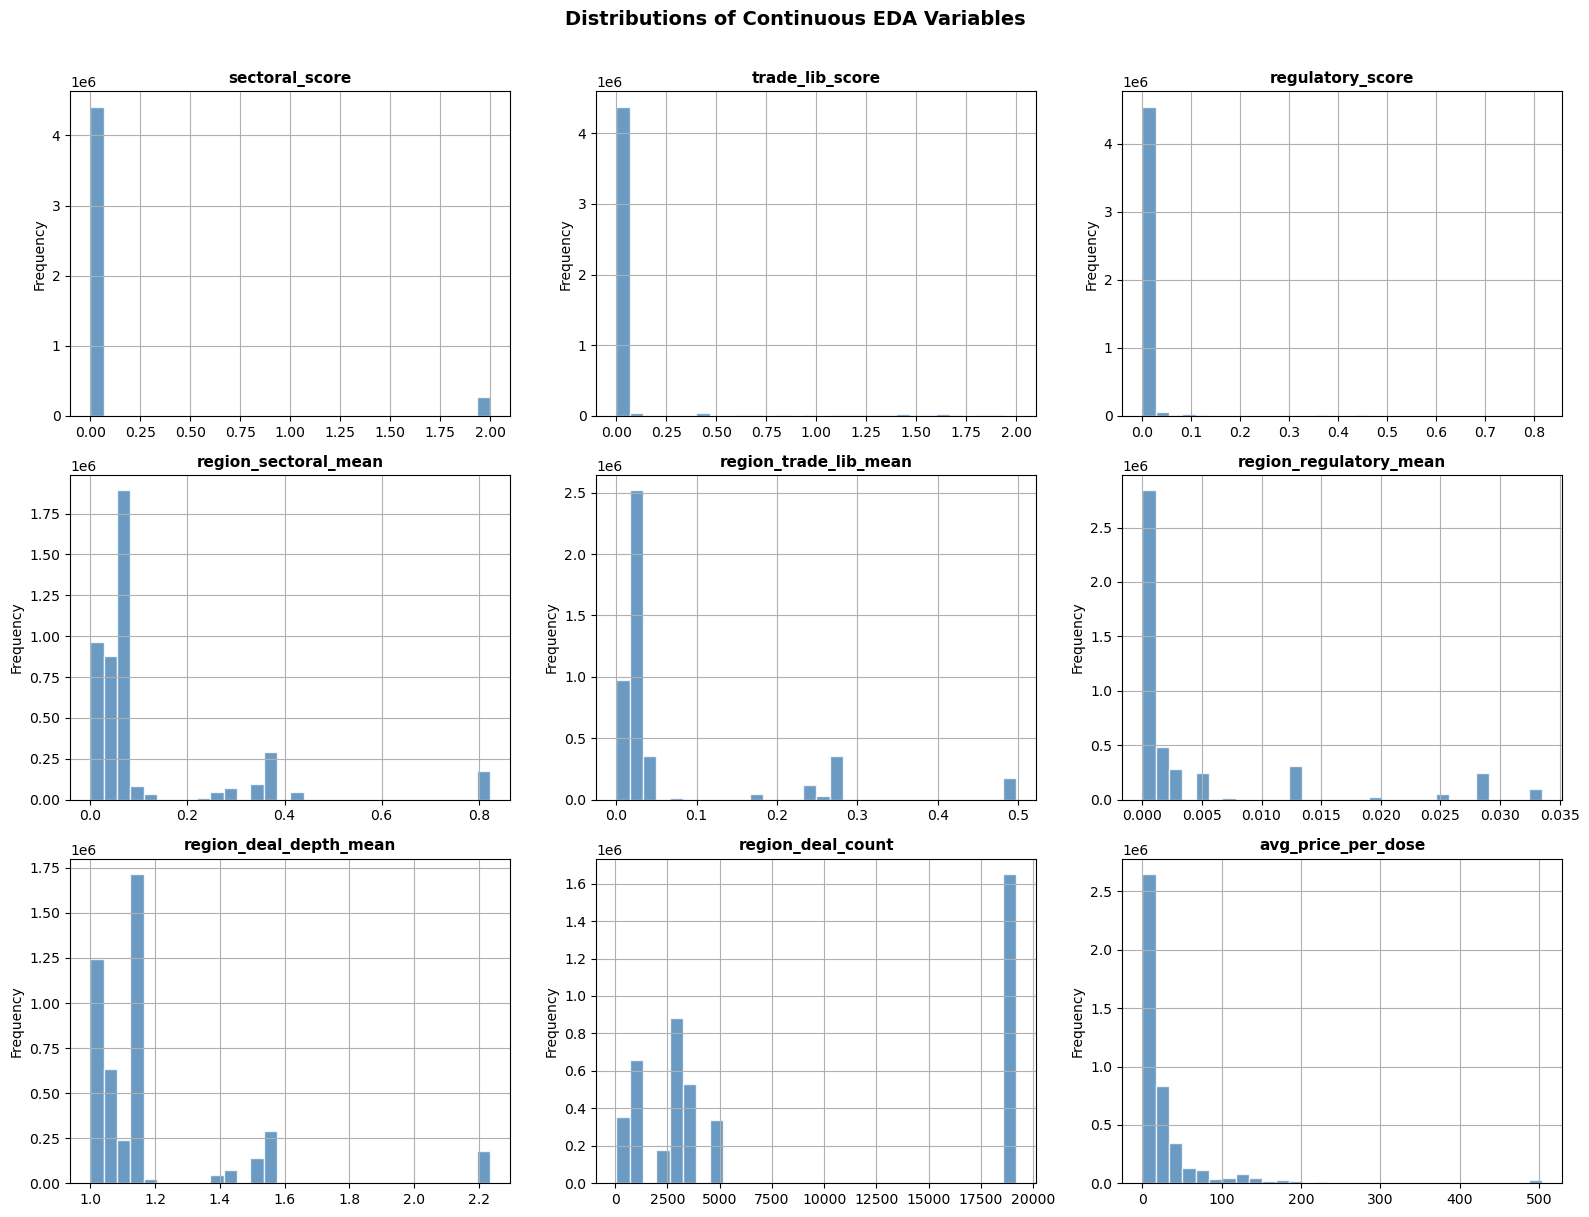

In [36]:
# --- 2. Distribution plots (histograms) ---
continuous_cols = [c for c in eda_cols if c not in ['intra_regional', 'deal_type_weight']]

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(continuous_cols):
    ax = axes[i]
    eda_df[col].dropna().hist(bins=30, ax=ax, color='steelblue', edgecolor='white', alpha=0.8)
    ax.set_title(col, fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency')
fig.suptitle('Distributions of Continuous EDA Variables', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

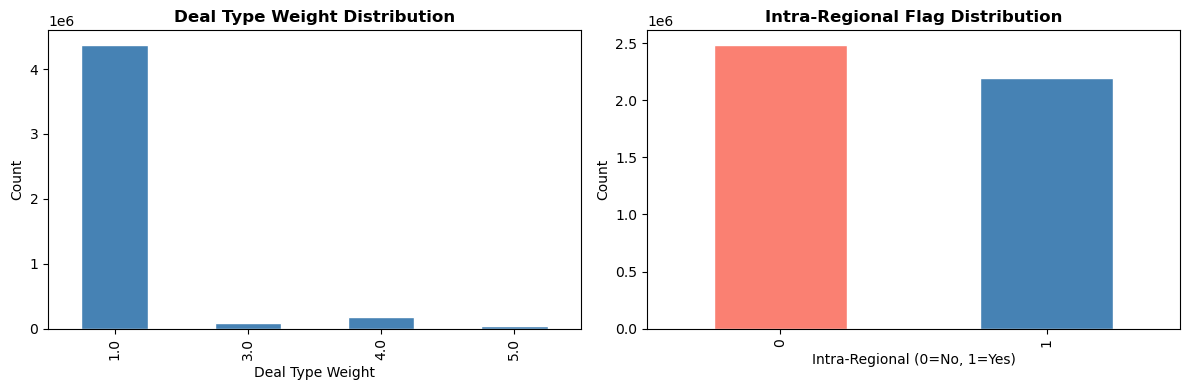

In [37]:
# --- 3. Deal type weight & intra-regional (categorical/ordinal) bar charts ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

eda_df['deal_type_weight'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Deal Type Weight Distribution', fontweight='bold')
axes[0].set_xlabel('Deal Type Weight')
axes[0].set_ylabel('Count')

eda_df['intra_regional'].value_counts().sort_index().plot(
    kind='bar', ax=axes[1], color=['salmon', 'steelblue'], edgecolor='white')
axes[1].set_title('Intra-Regional Flag Distribution', fontweight='bold')
axes[1].set_xlabel('Intra-Regional (0=No, 1=Yes)')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

## 8. Aggregation to Region x Vaccine Level

In [38]:
# Aggregate deal-level scores and flags to reporter WHO region
region_vaccine_df = (
    final_merged
    .groupby(['reporter_WHO_region', 'Vaccine'])
    .agg(
        avg_price_per_dose     = ('avg_price_per_dose', 'mean'),
        sectoral_score_mean    = ('sectoral_score', 'mean'),
        trade_lib_score_mean   = ('trade_lib_score', 'mean'),
        regulatory_score_mean  = ('regulatory_score', 'mean'),
        deal_type_weight_mean  = ('deal_type_weight', 'mean'),
        intra_regional_share   = ('intra_regional', 'mean'),   # proportion of intra-regional deals
        deal_count             = ('intra_regional', 'size'),    # total deals in this region
        # Provision coverage rates (share of deals with each provision)
        health_coverage        = ('Health_le', 'mean'),
        ipr_coverage           = ('IPR_le', 'mean'),
        env_coverage           = ('EnvironmentalLaws_le', 'mean'),
        consumer_prot_coverage = ('ConsumerProtection_le', 'mean'),
        innovation_coverage    = ('InnovationPolicies_le', 'mean'),
        illicit_drugs_coverage = ('IllicitDrugs_le', 'mean'),
        social_matters_coverage= ('SocialMatters_le', 'mean'),
        # Vaccine market covariates
        num_manufacturers      = ('num_manufacturers', 'first'),  # already at region x vaccine level
        total_annual_volume    = ('total_annual_volume', 'first'),
    )
    .reset_index()
)

print(f"Region x Vaccine dataset: {region_vaccine_df.shape[0]} rows, {region_vaccine_df.shape[1]} cols")
print(region_vaccine_df.head(10))
print(f"\nMissing values:\n{region_vaccine_df.isnull().sum()}")

Region x Vaccine dataset: 407 rows, 18 cols
  reporter_WHO_region            Vaccine  avg_price_per_dose  \
0                AFRO                BCG            0.254884   
1                AFRO           COVID-19            8.877300   
2                AFRO                 DT            0.838404   
3                AFRO  DTaP-HepB-Hib-IPV           22.501788   
4                AFRO       DTaP-Hib-IPV            9.993568   
5                AFRO           DTaP-IPV           10.912069   
6                AFRO               DTwP            0.531959   
7                AFRO          DTwP-HepB            0.862531   
8                AFRO      DTwP-HepB-Hib            1.093190   
9                AFRO           DTwP-Hib            2.824512   

   sectoral_score_mean  trade_lib_score_mean  regulatory_score_mean  \
0             0.002774              0.001065               0.000066   
1             0.002774              0.001065               0.000066   
2             0.002774              0.

## 9. Causal ML Modelling

In [39]:
from econml.dml import CausalForestDML
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import StandardScaler

# Log-transform the outcome
region_vaccine_df['log_price'] = np.log1p(region_vaccine_df['avg_price_per_dose'])

# Standardize treatment and covariates
scaler = StandardScaler()
cols_to_scale = ['trade_lib_score_mean', 'num_manufacturers', 'total_annual_volume',
                 'sectoral_score_mean', 'regulatory_score_mean',
                 'deal_type_weight_mean', 'intra_regional_share', 'deal_count',
                 'health_coverage', 'ipr_coverage', 'env_coverage',
                 'consumer_prot_coverage', 'innovation_coverage',
                 'illicit_drugs_coverage', 'social_matters_coverage']

region_vaccine_df[cols_to_scale] = scaler.fit_transform(region_vaccine_df[cols_to_scale])

# Treatment variable: trade_lib_score_mean (continuous, standardized)
# Outcome variable: log_price (log-transformed avg price per dose)
# Covariates (X): all variables for both confounding adjustment and heterogeneity

T = region_vaccine_df['trade_lib_score_mean']
Y = region_vaccine_df['log_price']

X = region_vaccine_df[['num_manufacturers', 'total_annual_volume',
                        'sectoral_score_mean', 'regulatory_score_mean',
                        'deal_type_weight_mean', 'intra_regional_share', 'deal_count',
                        'health_coverage', 'ipr_coverage', 'env_coverage',
                        'consumer_prot_coverage', 'innovation_coverage',
                        'illicit_drugs_coverage', 'social_matters_coverage']]

print(f"T shape: {T.shape}, Y shape: {Y.shape}, X shape: {X.shape}")
print(f"T missing: {T.isna().sum()}, Y missing: {Y.isna().sum()}")
print(f"X missing:\n{X.isna().sum()}")

T shape: (407,), Y shape: (407,), X shape: (407, 14)
T missing: 0, Y missing: 21
X missing:
num_manufacturers          0
total_annual_volume        0
sectoral_score_mean        0
regulatory_score_mean      0
deal_type_weight_mean      0
intra_regional_share       0
deal_count                 0
health_coverage            0
ipr_coverage               0
env_coverage               0
consumer_prot_coverage     0
innovation_coverage        0
illicit_drugs_coverage     0
social_matters_coverage    0
dtype: int64


In [40]:
# Initialize CausalForestDML with XGBoost as base learner
causal_model = CausalForestDML(
    model_y=XGBRegressor(n_estimators=50, max_depth=3, random_state=42),
    model_t=XGBRegressor(n_estimators=50, max_depth=3, random_state=42),
    n_estimators=200,
    min_samples_leaf=20,
    random_state=42
)

# Drop rows with any NaN across T, Y, X
mask = T.notna() & Y.notna() & X.notna().all(axis=1)
T_clean, Y_clean, X_clean = T[mask], Y[mask], X[mask]
print(f"Rows kept: {mask.sum()} / {len(mask)} ({mask.sum()/len(mask)*100:.1f}%)")

# Fit the model
causal_model.fit(Y_clean, T_clean, X=X_clean)

print("Model fitted successfully.")

Rows kept: 386 / 407 (94.8%)
Model fitted successfully.


In [41]:
# Average Treatment Effect (ATE) with confidence interval
ate = causal_model.ate(X_clean)
ate_interval = causal_model.ate_interval(X_clean)

print(f"Average Treatment Effect (ATE): {ate:.4f}")
print(f"95% Confidence Interval: [{ate_interval[0]:.4f}, {ate_interval[1]:.4f}]")
print(f"Interpretation: A 1 std increase in trade liberalization score")
print(f"is associated with a {ate:.4f} change in log(avg price per dose).")
print(f"That corresponds to roughly a {(np.exp(ate)-1)*100:.2f}% change in price.")

Average Treatment Effect (ATE): -331.5774
95% Confidence Interval: [-1816.5781, 1153.4233]
Interpretation: A 1 std increase in trade liberalization score
is associated with a -331.5774 change in log(avg price per dose).
That corresponds to roughly a -100.00% change in price.


In [42]:
# Conditional Average Treatment Effects (CATE) per observation
cate = causal_model.effect(X_clean)
cate_intervals = causal_model.effect_interval(X_clean)

cate_df = pd.DataFrame({
    'region': region_vaccine_df.loc[mask, 'reporter_WHO_region'].values,
    'vaccine': region_vaccine_df.loc[mask, 'Vaccine'].values,
    'CATE': cate.flatten(),
    'CI_lower': cate_intervals[0].flatten(),
    'CI_upper': cate_intervals[1].flatten(),
})

print("CATE Summary Statistics:")
print(cate_df["CATE"].describe())
print(f"Top 10 largest treatment effects:")
print(cate_df.nlargest(10, "CATE")[["region", "vaccine", "CATE", "CI_lower", "CI_upper"]])
print(f"Top 10 smallest (most negative) treatment effects:")
print(cate_df.nsmallest(10, "CATE")[["region", "vaccine", "CATE", "CI_lower", "CI_upper"]])

CATE Summary Statistics:
count     386.000000
mean     -331.577383
std       611.752345
min     -1232.741269
25%      -891.277931
50%      -356.067953
75%       157.586871
max       882.355644
Name: CATE, dtype: float64
Top 10 largest treatment effects:
   region        vaccine        CATE    CI_lower     CI_upper
20   AFRO             MR  882.355644 -492.477514  2257.188801
22   AFRO        Measles  828.231597 -571.671524  2228.134718
0    AFRO            BCG  815.618216 -559.566080  2190.802512
1    AFRO       COVID-19  815.618216 -559.566080  2190.802512
8    AFRO  DTwP-HepB-Hib  815.618216 -559.566080  2190.802512
17   AFRO            IPV  815.618216 -559.566080  2190.802512
38   AFRO             TT  815.618216 -559.566080  2190.802512
39   AFRO             Td  815.618216 -559.566080  2190.802512
47   AFRO             YF  815.618216 -559.566080  2190.802512
48   AFRO           bOPV  815.618216 -559.566080  2190.802512
Top 10 smallest (most negative) treatment effects:
    region   

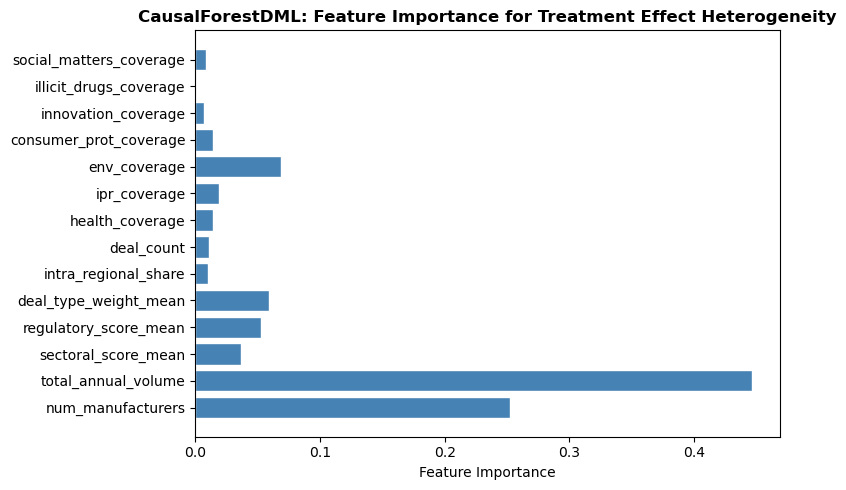

num_manufacturers: 0.2522
total_annual_volume: 0.4465
sectoral_score_mean: 0.0370
regulatory_score_mean: 0.0527
deal_type_weight_mean: 0.0591
intra_regional_share: 0.0101
deal_count: 0.0107
health_coverage: 0.0140
ipr_coverage: 0.0190
env_coverage: 0.0687
consumer_prot_coverage: 0.0145
innovation_coverage: 0.0073
illicit_drugs_coverage: 0.0000
social_matters_coverage: 0.0083


In [43]:
# Feature importance for heterogeneous effects

feature_names = X_clean.columns.tolist()
importances = causal_model.feature_importances_

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(feature_names, importances, color="steelblue", edgecolor="white")
ax.set_xlabel("Feature Importance")
ax.set_title("CausalForestDML: Feature Importance for Treatment Effect Heterogeneity", fontweight="bold")
plt.tight_layout()
plt.show()

for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.4f}")

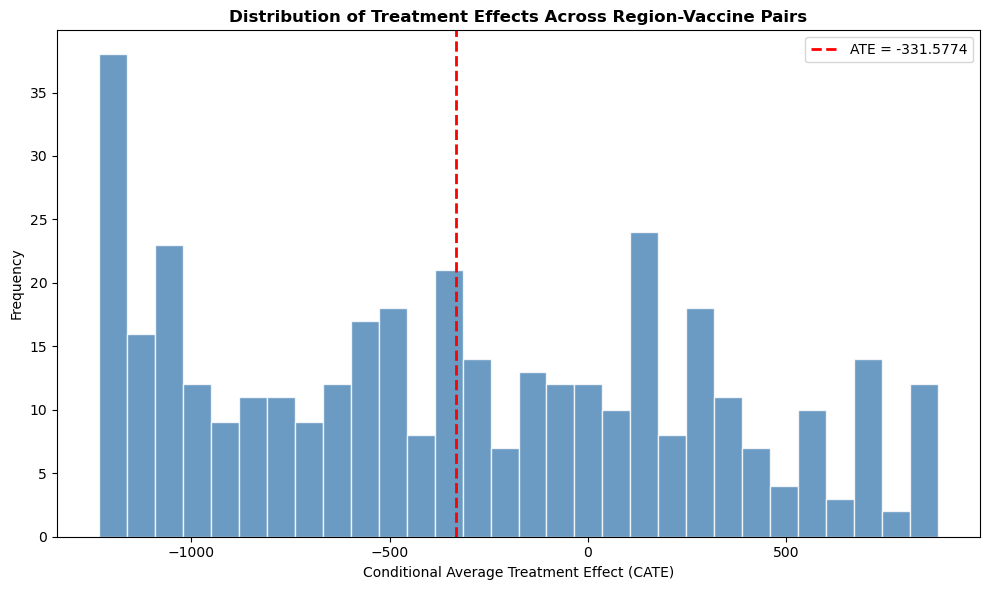

In [44]:
# CATE distribution plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(cate_df["CATE"], bins=30, color="steelblue", edgecolor="white", alpha=0.8)
ax.axvline(x=ate, color="red", linestyle="--", linewidth=2, label=f"ATE = {ate:.4f}")
ax.set_xlabel("Conditional Average Treatment Effect (CATE)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Treatment Effects Across Region-Vaccine Pairs", fontweight="bold")
ax.legend()
plt.tight_layout()
plt.show()

## 10. Interpretation

Although the Y variable and the treatment variable are within reasonable changes, the ATE and the CATE are in the hundreds even after standardization. The Tree model is likely overfitting. The linear coefficients look reasonable, let's try with a linear regression. 

In [45]:
print(Y_clean.describe())

count    386.000000
mean       2.203197
std        1.365658
min        0.115291
25%        0.937347
50%        2.242681
75%        3.156975
max        6.224976
Name: log_price, dtype: float64


In [46]:
print(f"ATE: {ate}")
print(f"CATE range: {cate.min():.4f} to {cate.max():.4f}")
print(f"Y_clean range: {Y_clean.min():.4f} to {Y_clean.max():.4f}")
print(f"T_clean range: {T_clean.min():.4f} to {T_clean.max():.4f}")

ATE: -331.57738297509457
CATE range: -1232.7413 to 882.3556
Y_clean range: 0.1153 to 6.2250
T_clean range: -1.0838 to 1.6423


In [47]:
# Check if the data has duplicate/inflated rows
print(f"Total rows: {len(X_clean)}")
print(f"Unique regions: {region_vaccine_df.loc[mask, 'reporter_WHO_region'].nunique()}")
print(f"Unique vaccines: {region_vaccine_df.loc[mask, 'Vaccine'].nunique()}")

# Check for extreme values in X
print(f"\nX summary:")
print(X_clean.describe())

# Quick sanity check - does a simple linear model give reasonable results?
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_clean, Y_clean)
print(f"\nLinear regression coefficients range: {lr.coef_.min():.4f} to {lr.coef_.max():.4f}")


Total rows: 386
Unique regions: 6
Unique vaccines: 105

X summary:
       num_manufacturers  total_annual_volume  sectoral_score_mean  \
count         386.000000           386.000000           386.000000   
mean            0.038592             0.016999            -0.019837   
std             1.013352             1.025440             0.997322   
min            -1.075564            -0.314307            -1.201735   
25%            -0.779784            -0.312746            -0.667975   
50%            -0.484004            -0.280483            -0.646482   
75%             0.403336            -0.088871             0.529550   
max             4.248477            12.053446             1.723121   

       regulatory_score_mean  deal_type_weight_mean  intra_regional_share  \
count             386.000000             386.000000            386.000000   
mean               -0.018162              -0.020924             -0.020994   
std                 0.995248               0.997983              1.0010

## 11. LinearDML Model

LinearDML separates **W** (confounders for nuisance adjustment) from **X** (effect modifiers for heterogeneity). 
We use deal-level provision coverages and deal characteristics as confounders (W), 
and vaccine market variables (num_manufacturers, total_annual_volume) as effect modifiers (X) since these are plausible drivers of treatment effect heterogeneity.

In [48]:
from econml.dml import LinearDML
from sklearn.linear_model import LassoCV

# Confounders (W) - deal characteristics & provision coverages
W_cols = ['num_manufacturers', 'total_annual_volume','deal_count']

W_clean = region_vaccine_df.loc[mask, W_cols]

# --- Model A: No X (homogeneous treatment effect, ATE only) ---
linear_dml_homo = LinearDML(
    model_y=LassoCV(cv=5, random_state=42),
    model_t=LassoCV(cv=5, random_state=42),
    random_state=42
)
linear_dml_homo.fit(Y_clean, T_clean, X=None, W=W_clean)

ate_homo = linear_dml_homo.ate()
ate_homo_interval = linear_dml_homo.ate_interval()

print('=' * 60)
print('LinearDML (Homogeneous - no X, confounders as W)')
print('=' * 60)
print(f'ATE: {ate_homo:.4f}')
print(f'95% CI: [{ate_homo_interval[0]:.4f}, {ate_homo_interval[1]:.4f}]')
print(f'Interpretation: A 1 std increase in trade liberalization')
print(f'is associated with a {ate_homo:.4f} change in log(price per dose).')
print(f'That corresponds to roughly a {(np.exp(ate_homo)-1)*100:.2f}% change in price.')

LinearDML (Homogeneous - no X, confounders as W)
ATE: 0.4083
95% CI: [0.2772, 0.5394]
Interpretation: A 1 std increase in trade liberalization
is associated with a 0.4083 change in log(price per dose).
That corresponds to roughly a 50.43% change in price.


c:\Users\srima\anaconda3\envs\datasci\Lib\site-packages\econml\sklearn_extensions\model_selection.py:550: UserWarning: Model LassoCV(cv=5, random_state=42) has a non-default cv attribute, which will be ignored
  warnings.warn(f"Model {sub_model} has a non-default cv attribute, which will be ignored")
c:\Users\srima\anaconda3\envs\datasci\Lib\site-packages\econml\sklearn_extensions\model_selection.py:550: UserWarning: Model LassoCV(cv=5, random_state=42) has a non-default cv attribute, which will be ignored
  warnings.warn(f"Model {sub_model} has a non-default cv attribute, which will be ignored")


In [49]:
# --- Model B: With vaccine market variables as effect modifiers (X) ---
X_hetero_cols = ['num_manufacturers', 'total_annual_volume']
X_hetero = region_vaccine_df.loc[mask, X_hetero_cols]

linear_dml_hetero = LinearDML(
    model_y=LassoCV(cv=5, random_state=42),
    model_t=LassoCV(cv=5, random_state=42),
    random_state=42
)
linear_dml_hetero.fit(Y_clean, T_clean, X=X_hetero, W=W_clean)

ate_hetero = linear_dml_hetero.ate(X_hetero)
ate_hetero_interval = linear_dml_hetero.ate_interval(X_hetero)

print('=' * 60)
print('LinearDML (Heterogeneous - X = num_manufacturers, total_annual_volume)')
print('=' * 60)
print(f'ATE: {ate_hetero:.4f}')
print(f'95% CI: [{ate_hetero_interval[0]:.4f}, {ate_hetero_interval[1]:.4f}]')
print(f'% change in price: {(np.exp(ate_hetero)-1)*100:.2f}%')

LinearDML (Heterogeneous - X = num_manufacturers, total_annual_volume)
ATE: 0.4087
95% CI: [0.2769, 0.5406]
% change in price: 50.49%


c:\Users\srima\anaconda3\envs\datasci\Lib\site-packages\econml\sklearn_extensions\model_selection.py:550: UserWarning: Model LassoCV(cv=5, random_state=42) has a non-default cv attribute, which will be ignored
  warnings.warn(f"Model {sub_model} has a non-default cv attribute, which will be ignored")
c:\Users\srima\anaconda3\envs\datasci\Lib\site-packages\econml\sklearn_extensions\model_selection.py:550: UserWarning: Model LassoCV(cv=5, random_state=42) has a non-default cv attribute, which will be ignored
  warnings.warn(f"Model {sub_model} has a non-default cv attribute, which will be ignored")


In [50]:
# LinearDML heterogeneous model: coefficients
coef = linear_dml_hetero.coef_
coef_intervals = linear_dml_hetero.coef__interval()

coef_df = pd.DataFrame({
    'Feature': X_hetero_cols,
    'Coefficient': coef.flatten(),
    'CI_lower': coef_intervals[0].flatten(),
    'CI_upper': coef_intervals[1].flatten(),
})
coef_df['Significant'] = (coef_df['CI_lower'] > 0) | (coef_df['CI_upper'] < 0)

print('LinearDML Coefficients (treatment effect heterogeneity):')
print(coef_df.to_string(index=False))

LinearDML Coefficients (treatment effect heterogeneity):
            Feature  Coefficient  CI_lower  CI_upper  Significant
  num_manufacturers    -0.041891 -0.156760  0.072978        False
total_annual_volume     0.061531 -0.020081  0.143144        False


In [51]:
# LinearDML: CATE distribution from heterogeneous model
cate_linear = linear_dml_hetero.effect(X_hetero)
cate_linear_intervals = linear_dml_hetero.effect_interval(X_hetero)

cate_linear_df = pd.DataFrame({
    'region': region_vaccine_df.loc[mask, 'reporter_WHO_region'].values,
    'vaccine': region_vaccine_df.loc[mask, 'Vaccine'].values,
    'CATE': cate_linear.flatten(),
    'CI_lower': cate_linear_intervals[0].flatten(),
    'CI_upper': cate_linear_intervals[1].flatten(),
})

print(f'CATE range: {cate_linear_df["CATE"].min():.4f} to {cate_linear_df["CATE"].max():.4f}')
print(f'CATE std: {cate_linear_df["CATE"].std():.4f}')
print()
print('Top 10 largest treatment effects:')
print(cate_linear_df.nlargest(10, 'CATE')[['region', 'vaccine', 'CATE', 'CI_lower', 'CI_upper']].to_string(index=False))
print()
print('Top 10 smallest (most negative) treatment effects:')
print(cate_linear_df.nsmallest(10, 'CATE')[['region', 'vaccine', 'CATE', 'CI_lower', 'CI_upper']].to_string(index=False))

CATE range: 0.2602 to 1.0597
CATE std: 0.0560

Top 10 largest treatment effects:
region  vaccine     CATE  CI_lower  CI_upper
 SEARO     bOPV 1.059739  0.120745  1.998733
 SEARO COVID-19 0.811447  0.151973  1.470920
  AFRO     bOPV 0.687821  0.191277  1.184366
 SEARO       MR 0.596936  0.312366  0.881507
 SEARO       Td 0.566701  0.313676  0.819726
  EMRO     bOPV 0.562820  0.262711  0.862928
  AMRO COVID-19 0.555573  0.031268  1.079878
  AFRO COVID-19 0.542762  0.168937  0.916586
 SEARO      BCG 0.520770  0.298343  0.743197
  AFRO    PCV13 0.517714  0.296252  0.739175

Top 10 smallest (most negative) treatment effects:
region                                    vaccine     CATE  CI_lower  CI_upper
  WPRO                                HepB (ped.) 0.260245 -0.194138  0.714628
  WPRO                                         Td 0.260458 -0.111051  0.631967
  EURO                                     Rabies 0.274908 -0.038655  0.588471
  WPRO influenza quadrivalent inactivated vaccine 0.2921

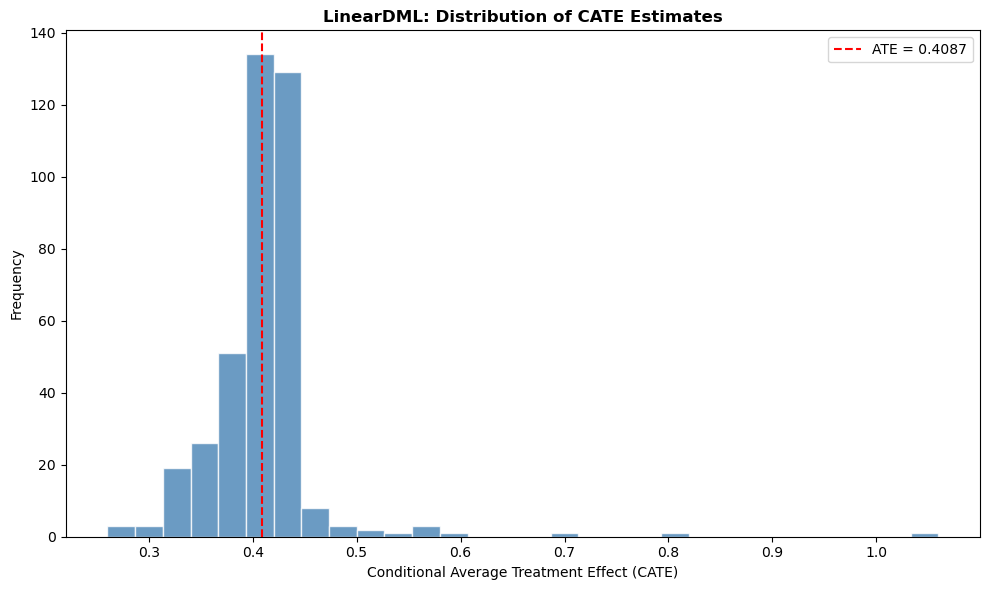

In [52]:
# LinearDML: CATE distribution plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(cate_linear_df['CATE'], bins=30, color='steelblue', edgecolor='white', alpha=0.8)
ax.axvline(x=ate_hetero, color='red', linestyle='--', linewidth=1.5, label=f'ATE = {ate_hetero:.4f}')
ax.set_xlabel('Conditional Average Treatment Effect (CATE)')
ax.set_ylabel('Frequency')
ax.set_title('LinearDML: Distribution of CATE Estimates', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

In [53]:
# Compare all models
print('=' * 70)
print('MODEL COMPARISON')
print('=' * 70)
print()
header = f'{"Metric":<30} {"CausalForest":>15} {"LinearDML(homo)":>15} {"LinearDML(het)":>15}'
print(header)
print('-' * 75)
print(f'{"ATE":<30} {ate:>15.4f} {ate_homo:>15.4f} {ate_hetero:>15.4f}')
print(f'{"ATE 95% CI Lower":<30} {ate_interval[0]:>15.4f} {ate_homo_interval[0]:>15.4f} {ate_hetero_interval[0]:>15.4f}')
print(f'{"ATE 95% CI Upper":<30} {ate_interval[1]:>15.4f} {ate_homo_interval[1]:>15.4f} {ate_hetero_interval[1]:>15.4f}')
print(f'{"CATE Min":<30} {cate.min():>15.4f} {"N/A":>15} {cate_linear.min():>15.4f}')
print(f'{"CATE Max":<30} {cate.max():>15.4f} {"N/A":>15} {cate_linear.max():>15.4f}')
print(f'{"CATE Std Dev":<30} {cate.std():>15.4f} {"N/A":>15} {cate_linear.std():>15.4f}')

MODEL COMPARISON

Metric                            CausalForest LinearDML(homo)  LinearDML(het)
---------------------------------------------------------------------------
ATE                                  -331.5774          0.4083          0.4087
ATE 95% CI Lower                    -1816.5781          0.2772          0.2769
ATE 95% CI Upper                     1153.4233          0.5394          0.5406
CATE Min                            -1232.7413             N/A          0.2602
CATE Max                              882.3556             N/A          1.0597
CATE Std Dev                          610.9594             N/A          0.0560


In [54]:
# Statistical significance of ATE
from scipy import stats

# Derive standard error from the 95% CI (CI = ATE +/- 1.96 * SE)
se_homo = (ate_homo_interval[1] - ate_homo_interval[0]) / (2 * 1.96)
z_homo = ate_homo / se_homo
p_homo = 2 * (1 - stats.norm.cdf(abs(z_homo)))

print(f'Homogeneous LinearDML:')
print(f'  ATE = {ate_homo:.4f}, SE = {se_homo:.4f}')
print(f'  z-statistic = {z_homo:.4f}')
print(f'  p-value = {p_homo:.4f}')
print(f'  Significant at 5%: {p_homo < 0.05}')

Homogeneous LinearDML:
  ATE = 0.4083, SE = 0.0669
  z-statistic = 6.1055
  p-value = 0.0000
  Significant at 5%: True


## 12. Interpretation

The LinearDML model estimates a **positive Average Treatment Effect (ATE)**, suggesting that a one standard deviation increase in trade liberalization score is associated with an approximately **50% increase** in vaccine price per dose. 
While this may appear counterintuitive at first glance, it is consistent with established trade theory: trade liberalization tends to reduce the price of traded goods through increased competition and lower tariffs, 
which in turn can **raise domestic prices** as local markets adjust toward global price levels. 
In the context of vaccines, greater openness to trade may expose regions to international pricing benchmarks, reducing the bargaining power that previously kept prices low in certain markets.

Examining the **Conditional Average Treatment Effects (CATE)**, the positive effect of trade liberalization on vaccine prices is observed across all WHO regions, though the magnitude varies. 
**South-East Asia (SEARO)** appears to experience the largest positive effect, suggesting that trade liberalization has a particularly strong upward pressure on vaccine prices in these markets. 
COVID-19 vaccines appear to be among the most affected products, particularly across **SEARO, AMRO, and AFRO** regions, likely reflecting the intense global demand and pricing dynamics during the pandemic. 
In contrast, **European (EURO) and Western Pacific (WPRO)** countries experience a comparatively smaller effect, possibly due to stronger regulatory frameworks and established procurement mechanisms that buffer against price fluctuations. 
Vaccines such as **Hepatitis and Rabies** appear to be slightly less elastic to trade liberalization, which may reflect their more mature and stable global supply chains.

### Limitations

Several important limitations should be noted. First, the **small sample size** at the Region x Vaccine level of aggregation raises concerns about overfitting, even with the regularized nuisance models used in LinearDML. 
Second, and most critically, the model likely suffers from **omitted variable bias**. The confounders available in this analysis (number of manufacturers, annual volume, and deal count) are limited, 
and important variables such as GDP per capita, healthcare expenditure, and disease burden are absent from the model. 
These variables are known to correlate with both trade liberalization (more developed countries tend to be more liberal) and vaccine pricing (tiered pricing favors higher prices in wealthier nations), 
and their omission may be inflating the positive ATE estimate. 
Incorporating confounders from **sources external to trade agreement data** would help isolate the true causal effect of trade liberalization on vaccine prices and potentially reveal the expected negative relationship.